In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Inflow Data Exploration

In [2]:
inflows = pd.read_parquet('../data/ucsd-inflows.pqt', engine='pyarrow')
inflows

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,PAYCHECK,2477.02,2022-03-18,PAYCHECK
1,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-10-25,EXTERNAL_TRANSFER
2,0,acc_0,MISCELLANEOUS,6.29,2022-08-26,MISCELLANEOUS
3,0,acc_0,EXTERNAL_TRANSFER,277.00,2022-06-03,EXTERNAL_TRANSFER
4,0,acc_0,EXTERNAL_TRANSFER,100.00,2022-07-29,EXTERNAL_TRANSFER
...,...,...,...,...,...,...
513110,5941,acc_9524,EXTERNAL_TRANSFER,8.66,2023-01-21,EXTERNAL_TRANSFER
513111,5941,acc_9524,EXTERNAL_TRANSFER,267.13,2023-01-23,EXTERNAL_TRANSFER
513112,5941,acc_9524,EXTERNAL_TRANSFER,2.00,2023-01-24,EXTERNAL_TRANSFER
513113,5941,acc_9524,EXTERNAL_TRANSFER,207.16,2023-01-24,EXTERNAL_TRANSFER


In [3]:
# unique categories of the inflows data

in_categories = inflows['category'].value_counts()
in_categories

category
EXTERNAL_TRANSFER        156533
SELF_TRANSFER            110437
DEPOSIT                   61345
MISCELLANEOUS             55648
PAYCHECK                  33138
PAYCHECK_PLACEHOLDER      26087
REFUND                    23220
INVESTMENT_INCOME         17325
SMALL_DOLLAR_ADVANCE      13621
OTHER_BENEFITS             7708
TAX                        3405
LOAN                       2513
UNEMPLOYMENT_BENEFITS      1961
INSURANCE                   174
Name: count, dtype: int64

In [4]:
category_gain = inflows.groupby('category')['amount'].sum().sort_values(ascending=False)
inflows['posted_date'] = pd.to_datetime(inflows['posted_date'])

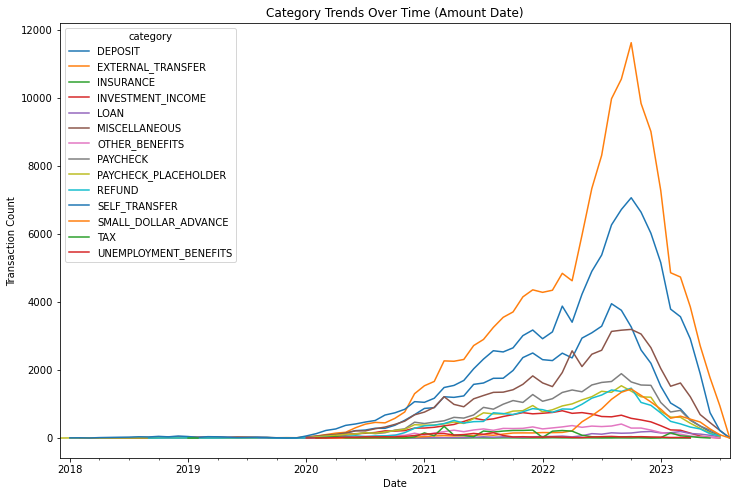

In [5]:
# total transaction per category over time

plt.figure(figsize=(12, 8))
inflows.groupby([inflows['posted_date'].dt.to_period('M'), 'category']).size().unstack().plot(kind='line', ax=plt.gca())
plt.title('Category Trends Over Time (Amount Date)')
plt.xlabel('Date')
plt.ylabel('Transaction Count')
plt.show()

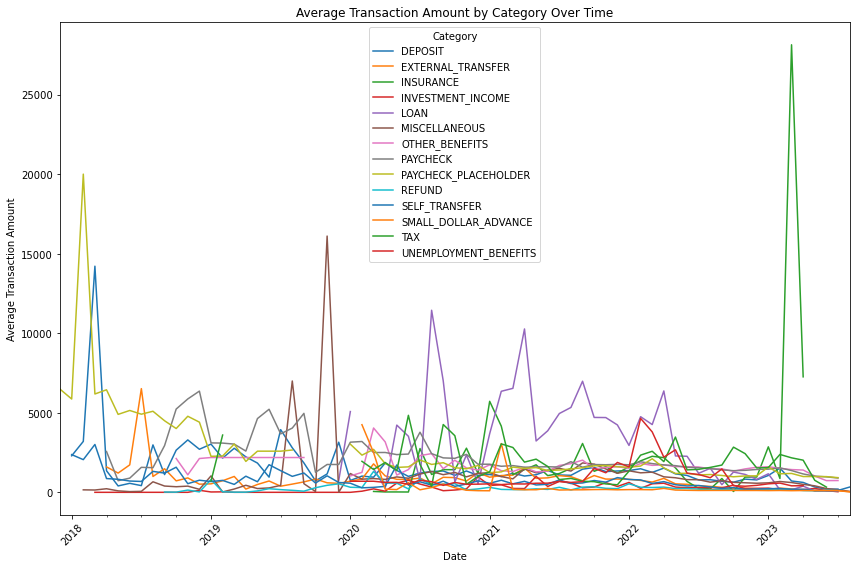

In [6]:
# average transaction amount per category over time

inflows['posted_date'] = pd.to_datetime(inflows['posted_date'])
avg_transaction = inflows.groupby([inflows['posted_date'].dt.to_period('M'), 'category'])['amount'].mean().unstack()

# Plot the result
plt.figure(figsize=(12, 8))
avg_transaction.plot(kind='line', ax=plt.gca())
plt.title('Average Transaction Amount by Category Over Time')
plt.xlabel('Date')
plt.ylabel('Average Transaction Amount')
plt.legend(title='Category')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

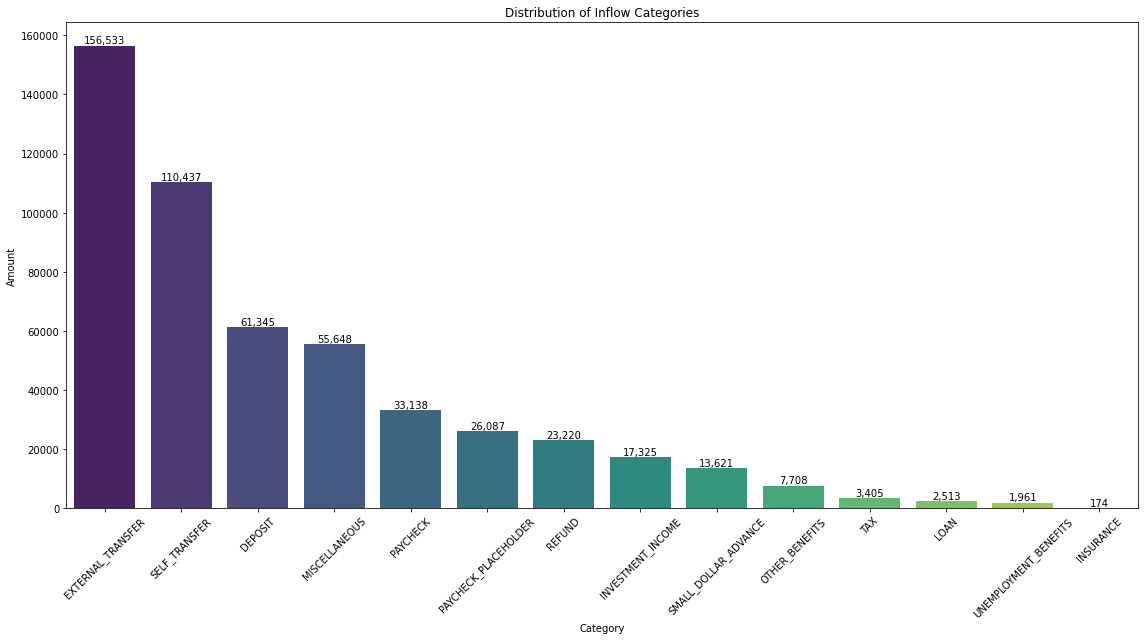

In [7]:
#frequency of categories

plt.figure(figsize=(16, 9))
bar_plot = sns.barplot(x=in_categories.index, y=in_categories, palette="viridis")

# Add labels on top of the bars
for index, value in enumerate(in_categories):
    plt.text(index, value, f'{value:,.0f}', ha='center', va='bottom')

# Set plot details
plt.title("Distribution of Inflow Categories")
plt.xlabel("Category")
plt.ylabel("Amount")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

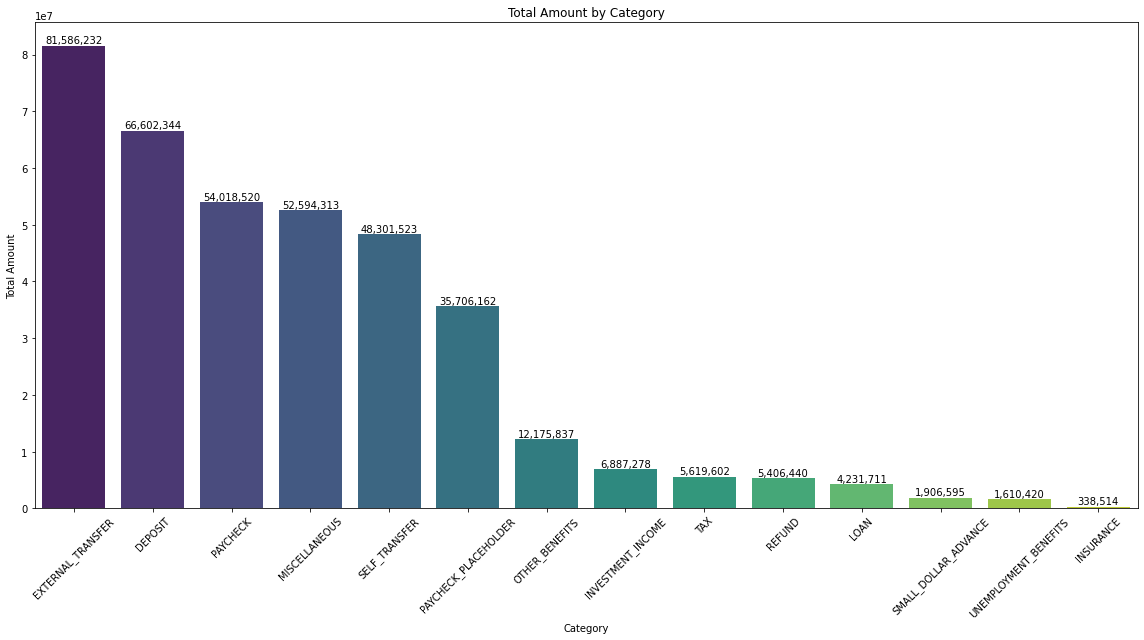

In [8]:
# total inflow per category

plt.figure(figsize=(16, 9))
bar_plot = sns.barplot(x=category_gain.index, y=category_gain, palette="viridis")

# Add labels on top of the bars
for index, value in enumerate(category_gain):
    plt.text(index, value, f'{value:,.0f}', ha='center', va='bottom')

# Set plot details
plt.title("Total Amount by Category")
plt.xlabel("Category")
plt.ylabel("Total Amount")
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

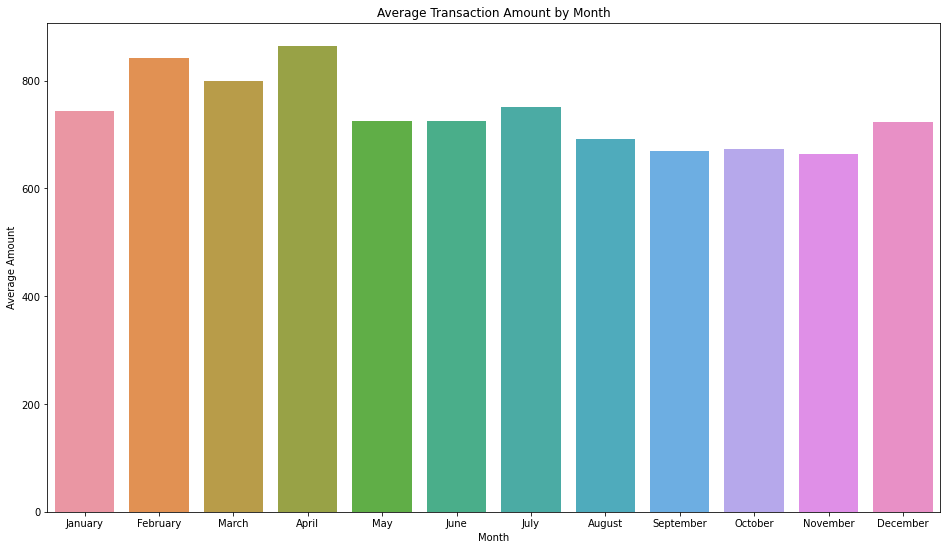

In [9]:
months = [
    "January", "February", "March", "April", "May", "June", 
    "July", "August", "September", "October", "November", "December"
]

# Convert 'posted_date' to datetime and extract the month
inflows['posted_date'] = pd.to_datetime(inflows['posted_date'])
inflows['month'] = inflows['posted_date'].dt.month_name()

# Group by month and calculate average amount
monthly_average = inflows.groupby('month')['amount'].mean().reindex(months)

# Plot the results
plt.figure(figsize=(16, 9))
sns.barplot(x=monthly_average.index, y=monthly_average)
plt.title("Average Transaction Amount by Month")
plt.xlabel("Month")
plt.ylabel("Average Amount")
plt.show()

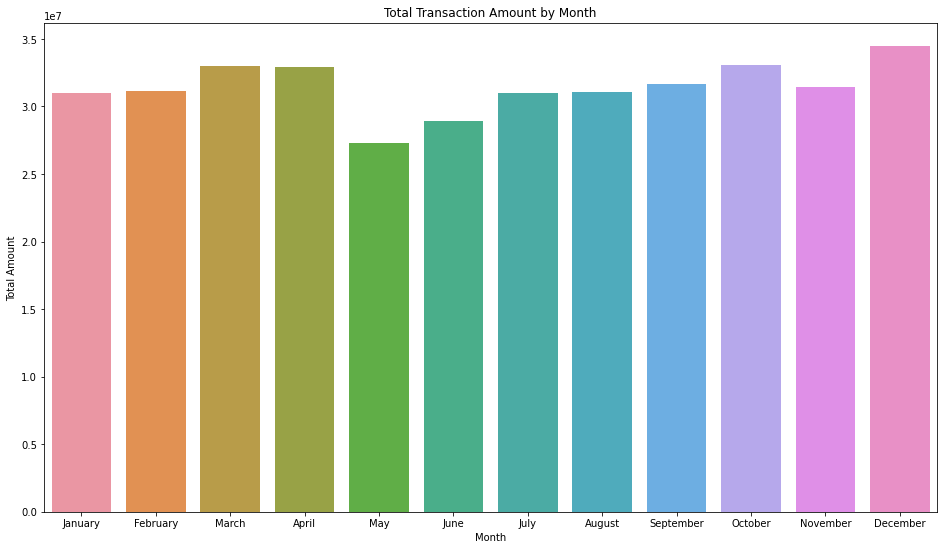

In [10]:
# Group by month and calculate average amount
monthly_total = inflows.groupby('month')['amount'].sum().reindex(months)

# Plot the results
plt.figure(figsize=(16, 9))
sns.barplot(x=monthly_total.index, y=monthly_total)
plt.title("Total Transaction Amount by Month")
plt.xlabel("Month")
plt.ylabel("Total Amount")
plt.show()

<AxesSubplot:xlabel='posted_date', ylabel='count'>

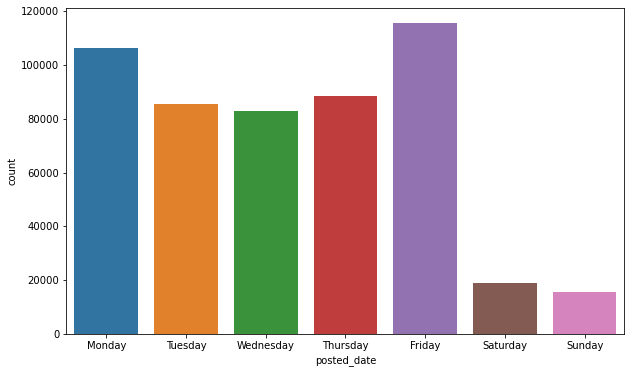

In [11]:
# let's look at what days of the week people are having the most transactions on
dates = pd.to_datetime(inflows['posted_date'])
day_of_week = dates.dt.day_name()
days_order = [
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
    "Sunday",
]

plt.figure(figsize=(10, 6))
counts = day_of_week.value_counts().reindex(days_order)

sns.barplot(x=counts.index, y=counts)

<AxesSubplot:xlabel='day', ylabel='amount'>

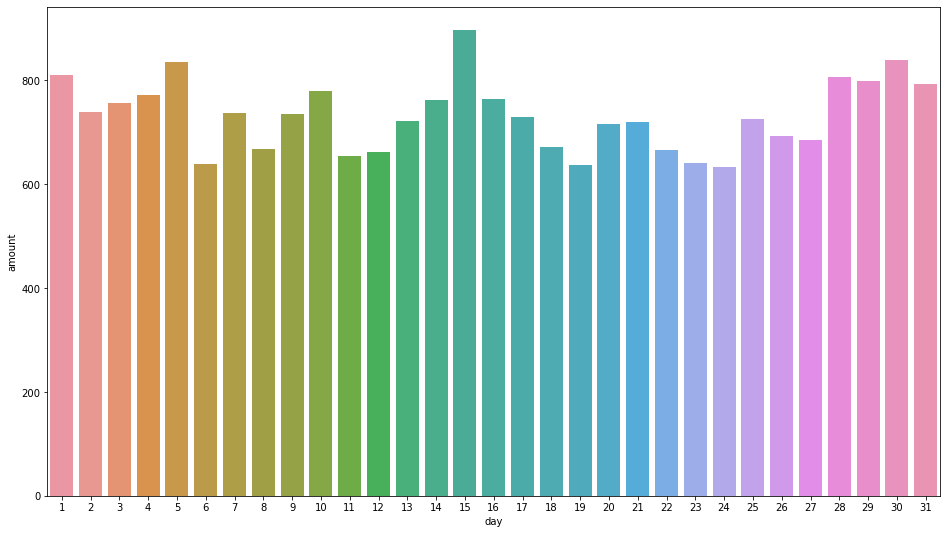

In [12]:
# Let's look at if there is a semblance of a pattern when looking at specific dates, and the amount of spending that happens on those days
numerical_categories = inflows[["amount", "posted_date"]].copy()
numerical_categories["posted_date"] = dates
numerical_categories["day"] = numerical_categories["posted_date"].dt.day
daily_average = numerical_categories.groupby("day")["amount"].mean()

plt.figure(figsize=(16, 9))
sns.barplot(x = daily_average.index, y = daily_average)

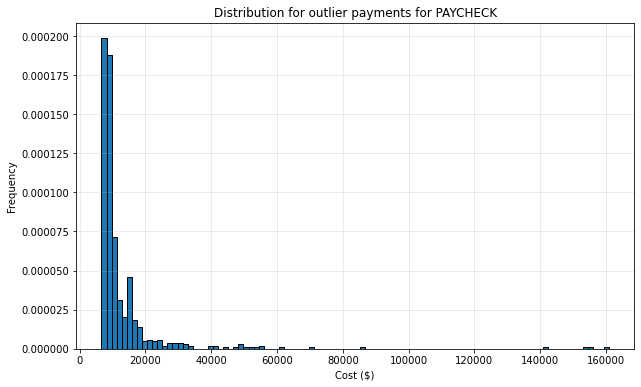

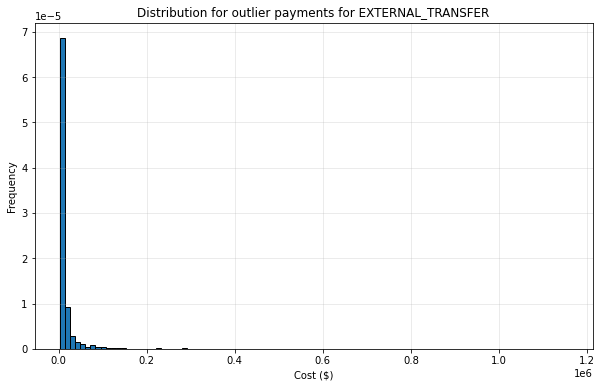

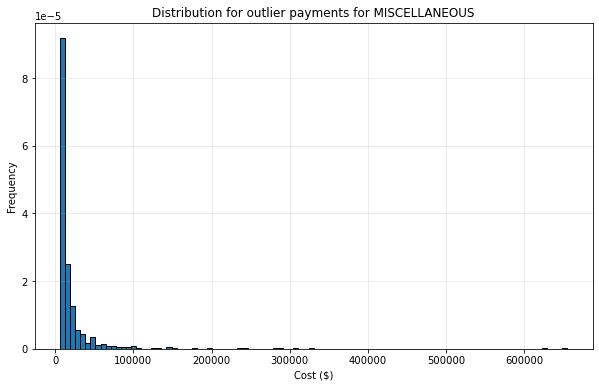

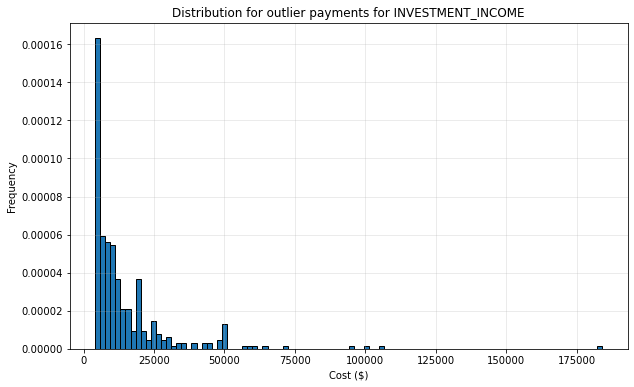

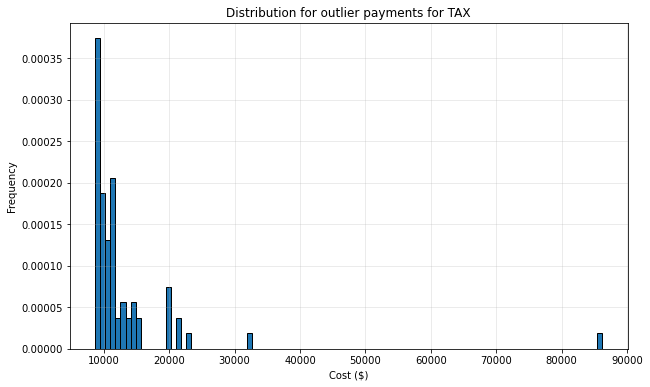

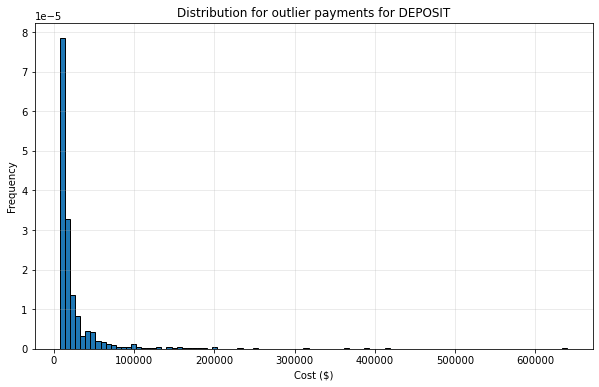

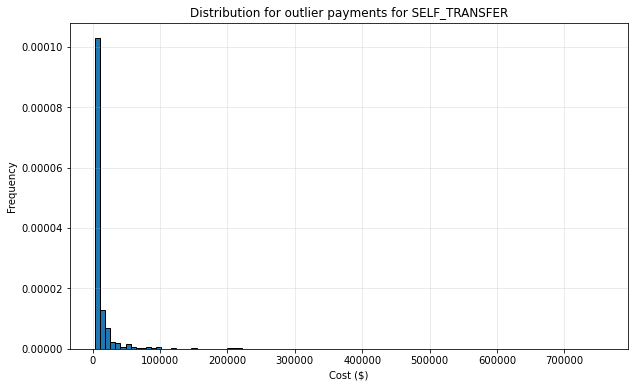

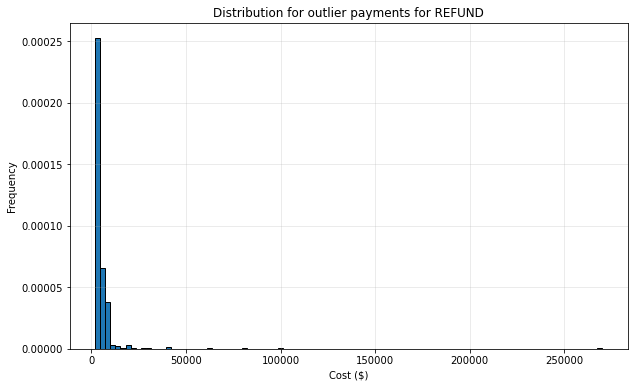

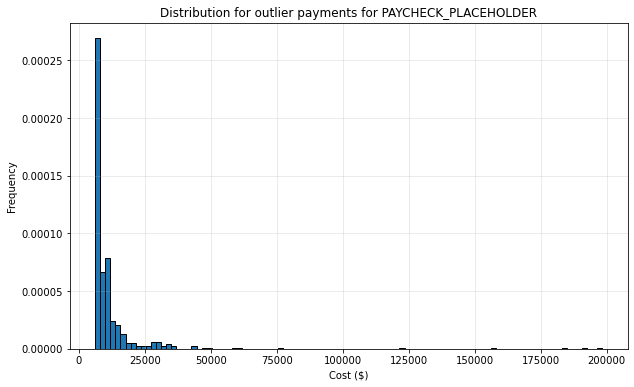

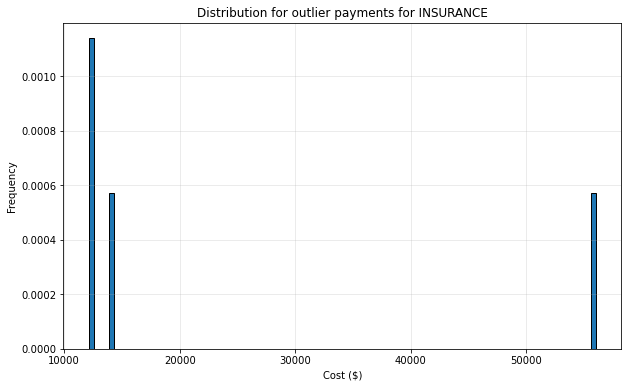

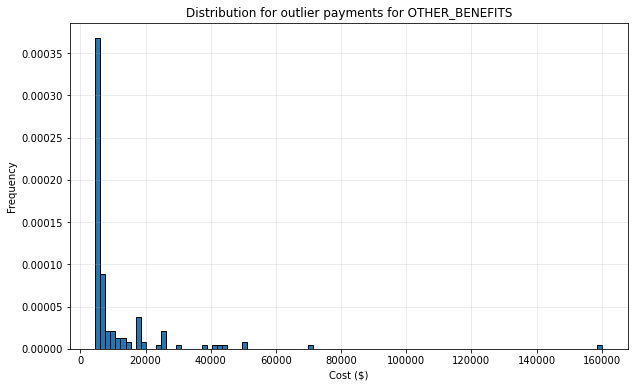

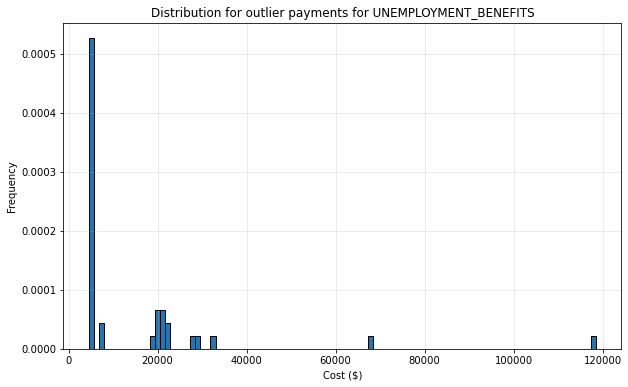

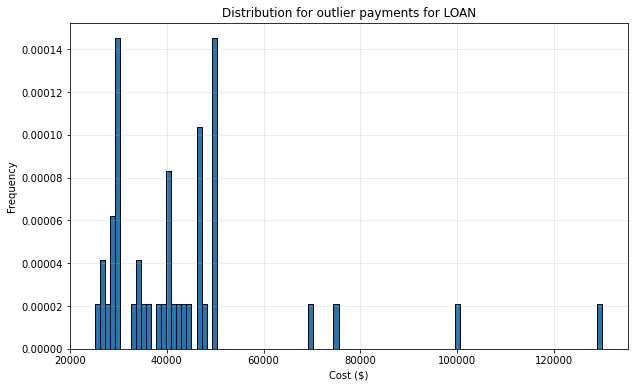

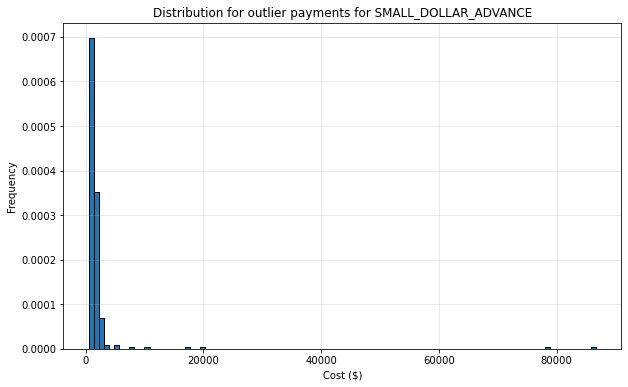

In [13]:
# outliers for inflows
categories = inflows["category"].unique()

# plotting all spending for different categories
for cat in categories:
    # limit to 95% of the spending (ignoring the top 5%)
    gain = inflows[inflows["category"] == cat]["amount"]

    threshold = np.percentile(gain, 98)
    outlier = gain[gain > threshold]

    plt.figure(figsize=(10, 6))
    plt.hist(outlier, bins=100, edgecolor="black", density=True)

    plt.xlabel(f"Cost ($)")
    plt.ylabel("Frequency")
    plt.title(f"Distribution for outlier payments for {cat}")

    plt.grid(True, alpha=0.3)
    plt.show()

In [14]:
common_merchant_inflow = inflows.groupby(['category', 'memo'])[['prism_consumer_id']].count().sort_values(by='prism_consumer_id', ascending=False).groupby('category').head(1)

In [15]:
common_merchant_inflow

,,prism_consumer_id
category,memo,
EXTERNAL_TRANSFER,EXTERNAL_TRANSFER,156533
SELF_TRANSFER,SELF_TRANSFER,110437
DEPOSIT,DEPOSIT,61345
MISCELLANEOUS,MISCELLANEOUS,55648
PAYCHECK,PAYCHECK,33138
PAYCHECK_PLACEHOLDER,PAYCHECK_PLACEHOLDER,26087
REFUND,REFUND,23220
INVESTMENT_INCOME,INVESTMENT_INCOME,17325
SMALL_DOLLAR_ADVANCE,SMALL_DOLLAR_ADVANCE,13621


# Outflow Data Exploration

In [16]:
outflows = pd.read_parquet('../data/ucsd-outflows.pqt', engine='pyarrow')
outflows

,prism_consumer_id,prism_account_id,memo,amount,posted_date,category
0,0,acc_0,LOAN,900.60,2022-07-05,LOAN
1,0,acc_0,ATM_CASH,80.00,2022-03-25,ATM_CASH
2,0,acc_0,TST* Casa Del Rio - Exp Fairlawn OH 09/24,18.42,2022-09-26,FOOD_AND_BEVERAGES
3,0,acc_0,LOAN,634.00,2023-01-10,LOAN
4,0,acc_0,Buffalo Wild Wings,26.47,2022-09-12,FOOD_AND_BEVERAGES
...,...,...,...,...,...,...
2597483,5941,acc_9524,ATM_CASH,8.42,2023-01-25,ATM_CASH
2597484,5941,acc_9524,ATM_CASH,2.06,2023-01-25,ATM_CASH
2597485,5941,acc_9524,ATM_CASH,262.88,2023-01-25,ATM_CASH
2597486,5941,acc_9524,ATM_CASH,10.00,2023-01-25,ATM_CASH


In [17]:
# unique categories of the outflows data

outflows['category'].value_counts()

category
GENERAL_MERCHANDISE    524063
FOOD_AND_BEVERAGES     481994
EXTERNAL_TRANSFER      320998
GROCERIES              219331
AUTOMOTIVE             208579
ATM_CASH               117651
UNCATEGORIZED          117409
LOAN                    90945
ENTERTAINMENT           80885
ESSENTIAL_SERVICES      77137
CREDIT_CARD_PAYMENT     75506
SELF_TRANSFER           73281
TRAVEL                  59647
HEALTHCARE_MEDICAL      40842
ACCOUNT_FEES            37511
INSURANCE               30244
PETS                     9266
HOME_IMPROVEMENT         8600
GIFTS_DONATIONS          4719
EDUCATION                4499
OVERDRAFT                3386
TAX                      3186
RENT                     3147
BNPL                     1543
MORTGAGE                 1119
PAYCHECK                 1040
CHILD_DEPENDENTS          936
BILLS_UTILITIES            23
AUTO_LOAN                   1
Name: count, dtype: int64

In [18]:
top_merchant_outflow_all = outflows.groupby(['category', 'memo'])[['prism_consumer_id']].count().sort_values(by='prism_consumer_id', ascending=False).groupby('category').head(1).reset_index()

In [19]:
top_merchant_outflow_all

,category,memo,prism_consumer_id
0,EXTERNAL_TRANSFER,EXTERNAL_TRANSFER,320998
1,AUTOMOTIVE,AUTOMOTIVE,208579
2,ATM_CASH,ATM_CASH,117651
3,UNCATEGORIZED,UNCATEGORIZED,117409
4,LOAN,LOAN,90945
5,ENTERTAINMENT,ENTERTAINMENT,80885
6,ESSENTIAL_SERVICES,ESSENTIAL_SERVICES,77137
7,CREDIT_CARD_PAYMENT,CREDIT_CARD_PAYMENT,75506
8,SELF_TRANSFER,SELF_TRANSFER,73281
9,HEALTHCARE_MEDICAL,HEALTHCARE_MEDICAL,40842


In [20]:
# remove category where the memo is exactly the same

top_merchant_outflow = top_merchant_outflow_all[top_merchant_outflow_all['category'] != top_merchant_outflow_all['memo']]

In [21]:
top_merchant_outflow

,category,memo,prism_consumer_id
11,GENERAL_MERCHANDISE,Amazon,31725
12,GROCERIES,Walmart,31619
14,FOOD_AND_BEVERAGES,McDonald's,22670
16,TRAVEL,Uber,7989
20,PETS,PetSmart,1450
23,OVERDRAFT,Overdraft Item Fee,374
24,EDUCATION,Teacherspayteachers.com,90
25,MORTGAGE,HUNTINGTON MORTG ONLINE PMT XXXXXX,52
26,RENT,SOUTHERN INVESTO WEB PMTS,47
